In [1]:
import os
import pandas as pd
import sys
import torch

sys.path.append("../")
# sys.path.append("../hms_pipeline")

from hms_pipeline.spec_dataset import SpecDataset, infer_spec_dataset
from hms_pipeline.eeg_model import SpecModel
from hms_pipeline.kaggle_kl_div import eval_subm, eval_subm_g10

GT_PATH = "/home/maxc/workspace/kaggle-hms/folds/all_targets.csv"

In [2]:
def read_subm_dir(subm_dir, sort_idx=-1):
    # in the subm dir, all the submission files have the format f{fold}_{epoch}_{score}.csv
    # get a list of the lowest score files in each fold
    subm_files = os.listdir(subm_dir)
    subm_file_list = []
    score_list = []
    
    # get how many folds there are, there might be multiple files from the same fold
    max_fold = 0
    for file in subm_files:
        if file.startswith("f"):
            fold = int(file[1])
            max_fold = max(max_fold, fold)
    print("Sort by the score at index", sort_idx)
    log_string = ""
    for fold in range(max_fold + 1):
        fold_files = [f for f in subm_files if f.startswith(f"f{fold}_")]
        # split the files into the epoch and score
        # remove the .csv but not the .
        fold_files = [f[:-4] for f in fold_files]
        # sort by score
        fold_files.sort(key=lambda x: float(x.split("_")[sort_idx]))
        file_name = fold_files[0]
        score = float(file_name.split("_")[2])
        score_list.append(score)
        subm_file_list.append(os.path.join(subm_dir, fold_files[0] + ".csv"))

        log_string += f"fold {fold}: {fold_files[0]} |"
        # print(f"fold {fold}: {fold_files[0]}")
    print(log_string)
    return subm_file_list, score_list

In [3]:
# def eval_subm_g10(subm, gt_subm):
#     g10_ids = gt_subm[gt_subm["total_votes"] >= 10]["eeg_id"].values
#     g10_subm = subm[subm["eeg_id"].isin(g10_ids)]
#     score = eval_subm(g10_subm, gt_subm)
#     return score

def eval_subm_dir(subm_dir, sort_idx=-1):
    subm_list, score_list = read_subm_dir(subm_dir, sort_idx=sort_idx)

    subm = pd.concat([pd.read_csv(f) for f in subm_list])
    gt_subm = pd.read_csv(GT_PATH)

    score = eval_subm(subm, gt_subm)
    g10_score = eval_subm_g10(subm, gt_subm)

    report_score_list = [g10_score, score] + score_list

    # get the ids where the total_votes in gt_subm is greater than 10
    print(f"Score: {score}", f"g10 score: {g10_score}")

    print(f"score list: {report_score_list}")
    return subm

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns



def analyze_subm(subm_df, gt_df, plot=False):
    origin_subm_df = subm_df.copy()
    subm_df = subm_df.copy()
    gt_df = gt_df.copy()
    
    gt_df['eeg_id'] = gt_df['eeg_id'].astype(int)
    gt_df['eeg_sub_id'] = gt_df['eeg_sub_id'].astype(int)
    subm_df['eeg_id'] = subm_df['eeg_id'].astype(int)
    subm_df['eeg_sub_id'] = subm_df['eeg_sub_id'].astype(int)

    # create unique id for each row from eeg_id and eeg_sub_id
    gt_df['unique_id'] = gt_df['eeg_id'].astype(str) + '_' + gt_df['eeg_sub_id'].astype(str)
    subm_df['unique_id'] = subm_df['eeg_id'].astype(str) + '_' + subm_df['eeg_sub_id'].astype(str)


    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    subm_df = subm_df[['unique_id'] + TARGETS]
    gt_df = gt_df[['unique_id'] + TARGETS]
    old_gt_df_shape = gt_df.shape
    subm_unique_ids = subm_df['unique_id']
    gt_df = gt_df[gt_df['unique_id'].isin(subm_unique_ids)]
    # print(old_gt_df_shape, gt_df.shape, subm_df.shape)
    
    assert gt_df.shape[0] == subm_df.shape[0], f"Submission and ground truth have different number of unique ids: {gt_df.shape[0]} vs {subm_df.shape[0]}"
    # sort gt_df and subm_df by unique_id
    gt_df.sort_values('unique_id', inplace=True)
    subm_df.sort_values('unique_id', inplace=True)

    gt_df.reset_index(drop=True, inplace=True)
    subm_df.reset_index(drop=True, inplace=True)
    # sort gt_df and subm_df by unique_id

    subm_target_tensor = torch.tensor(subm_df[TARGETS].values)
    gt_target_tensor = torch.tensor(gt_df[TARGETS].values)


    # print(subm_target_tensor.shape, gt_target_tensor.shape)
    kl_div = torch.nn.KLDivLoss(reduction='none')
      
    log_subm_target_tensor = torch.log(subm_target_tensor)
    # pred_kl = get_elementwise_kl(log_subm_target_tensor, gt_target_tensor)
    pred_kl = kl_div(log_subm_target_tensor, gt_target_tensor)

    # target mean kl_div
    per_target_mean_kl_div = pred_kl.mean(dim=0)
    # convert to list
    per_target_mean_kl_div = per_target_mean_kl_div.tolist()
    print(TARGETS)
    print(per_target_mean_kl_div)

    # sum over the 6 classes
    pred_kl = pred_kl.sum(dim=1)
    pred_kl_mean = pred_kl.mean()

    reverse_kl = kl_div(torch.log(gt_target_tensor+1e-6), subm_target_tensor)
    reverse_kl = reverse_kl.sum(dim=1)

    mean_pred = 1/6 * torch.ones_like(subm_target_tensor)
    mean_pred = torch.log(mean_pred)
    mean_kl = kl_div(mean_pred, gt_target_tensor)
    mean_kl = mean_kl.sum(dim=1)

    mean_pred_kl = kl_div(mean_pred, subm_target_tensor).sum(dim=1)

    origin_subm_df["mean_pred_kl"] = mean_pred_kl.detach().numpy()
    origin_subm_df["kl_div"] = pred_kl.detach().numpy()
    origin_subm_df["reverse_kl_div"] = reverse_kl.detach().numpy()
    origin_subm_df["mean_kl_div"] = mean_kl.detach().numpy()
    # plot two  plots side by side
    # plot mean kl_div vs kl_div

    if plot:
        fig, ax = plt.subplots(1, 4, figsize=(30, 5))

        sns.scatterplot(data=origin_subm_df, x="mean_kl_div", y="kl_div", ax=ax[0])
        # plot a line y=x
        ax[0].plot([0, 2], [0, 2], color='r')
        # plot a line of mean kl_div value
        ax[0].plot([0, 2], [pred_kl_mean, pred_kl_mean], color='g')
        ax[0].set_xlim(0, 2)
        ax[0].set_ylim(0, 10)

        # sns.scatterplot(data=origin_subm_df, x="mean_pred_kl", y="kl_div", ax=ax[1])
        # ax[1].plot([0, 2], [0, 2], color='r')
        # ax[1].plot([0, 2], [pred_kl_mean, pred_kl_mean], color='g')
        # ax[1].set_xlim(0, 2)
        # ax[1].set_ylim(0, 10)


        # plot a box plot of kl_div values
        # assign a group id by each 0.5 kl_div
        origin_subm_df['kl_div_group'] = (origin_subm_df['mean_kl_div'] * 4).astype(int) / 4
        sns.boxplot(data=origin_subm_df, x='kl_div_group', y='kl_div', ax=ax[1])
        # sns.histplot(data=origin_subm_df, x="mean_kl_div", bins=100, ax=ax[2],)
    # plot a sns histogram of the kl_div values
        sns.histplot(data=origin_subm_df, x="mean_pred_kl", bins=100, ax=ax[2],)
        ax[2].set_ylim(0, 500)

        # plot log scale y histogram of kl_div
        sns.histplot(data=origin_subm_df, x="kl_div", bins=100, ax=ax[3],)
        ax[3].set_yscale('log')
        # plot a vertical line of mean kl_div value
        ax[3].axvline(pred_kl_mean, color='g')
        ax[3].set_xlim(0, 12)


 
    return origin_subm_df

In [5]:
def analyze_subm_dir(subm_dir, plot=False):
    gt_subm = pd.read_csv(GT_PATH)

    subm = eval_subm_dir(subm_dir, sort_idx=-2)
    ming10_subm  = eval_subm_dir(subm_dir, sort_idx=-1)
    analyze_subm(subm, gt_subm, plot)
    analyze_subm(ming10_subm, gt_subm, plot)

In [6]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_12_0.5155_0.3235 |fold 1: f1_14_0.4606_0.3060 |fold 2: f2_9_0.4964_0.3175 |fold 3: f3_9_0.4990_0.3068 |fold 4: f4_12_0.4812_0.3076 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49053201932501905 g10 score: 0.2575353806454633
score list: [0.2575353806454633, 0.49053201932501905, 0.5155, 0.4606, 0.4964, 0.499, 0.4812]
Sort by the score at index -1
fold 0: f0_8_0.5325_0.3110 |fold 1: f1_9_0.4712_0.2951 |fold 2: f2_9_0.4964_0.3175 |fold 3: f3_9_0.4990_0.3068 |fold 4: f4_10_0.4840_0.3072 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4966199198095187 g10 score: 0.24976966790041
score list: [0.24976966790041, 0.4966199198095187, 0.5325, 0.4712, 0.4964, 0.499, 0.484]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.14492445987718278, 0.0660027714257047, 0.045974923747693144, 0.06685014203930782, 0.0856526369231467, 0.08112708531198394]
['seizure_vote', 'lpd_

In [7]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-ema/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_13_0.5393_0.3228 |fold 1: f1_12_0.4693_0.2990 |fold 2: f2_12_0.4962_0.3128 |fold 3: f3_11_0.4953_0.3351 |fold 4: f4_12_0.4840_0.3090 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4968306668443674 g10 score: 0.26616337774230764
score list: [0.26616337774230764, 0.4968306668443674, 0.5393, 0.4693, 0.4962, 0.4953, 0.484]
Sort by the score at index -1
fold 0: f0_11_0.5543_0.3210 |fold 1: f1_13_0.4807_0.2955 |fold 2: f2_10_0.5117_0.3117 |fold 3: f3_8_0.5025_0.3156 |fold 4: f4_13_0.4889_0.3042 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5076098582705122 g10 score: 0.2553673809161932
score list: [0.2553673809161932, 0.5076098582705122, 0.5543, 0.4807, 0.5117, 0.5025, 0.4889]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1316941943833464, 0.07187852900458724, 0.05027864383188595, 0.06716342474167664, 0.0960002726663066, 0.07981560221656465]
['seizure_vo

In [8]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-noema/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_13_0.5393_0.3228 |fold 1: f1_12_0.4693_0.2990 |fold 2: f2_12_0.4962_0.3128 |fold 3: f3_11_0.4953_0.3351 |fold 4: f4_12_0.4840_0.3090 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4968306668443674 g10 score: 0.26616337774230764
score list: [0.26616337774230764, 0.4968306668443674, 0.5393, 0.4693, 0.4962, 0.4953, 0.484]
Sort by the score at index -1
fold 0: f0_11_0.5543_0.3210 |fold 1: f1_13_0.4807_0.2955 |fold 2: f2_10_0.5117_0.3117 |fold 3: f3_8_0.5025_0.3156 |fold 4: f4_13_0.4889_0.3042 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5076098582705122 g10 score: 0.2553673809161932
score list: [0.2553673809161932, 0.5076098582705122, 0.5543, 0.4807, 0.5117, 0.5025, 0.4889]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1316941943833464, 0.07187852900458724, 0.05027864383188595, 0.06716342474167664, 0.0960002726663066, 0.07981560221656465]
['seizure_vo

In [9]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-ema-new-hook/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_10_0.5346_0.3139 |fold 1: f1_9_0.4686_0.2898 |fold 2: f2_9_0.5268_0.3206 |fold 3: f3_9_0.5108_0.3131 |fold 4: f4_9_0.4813_0.3004 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5043923146443732 g10 score: 0.2519590694092259
score list: [0.2519590694092259, 0.5043923146443732, 0.5346, 0.4686, 0.5268, 0.5108, 0.4813]
Sort by the score at index -1
fold 0: f0_10_0.5346_0.3139 |fold 1: f1_7_0.4764_0.2889 |fold 2: f2_7_0.5294_0.3167 |fold 3: f3_8_0.5136_0.3126 |fold 4: f4_9_0.4813_0.3004 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5070589022458878 g10 score: 0.250298759726325
score list: [0.250298759726325, 0.5070589022458878, 0.5346, 0.4764, 0.5294, 0.5136, 0.4813]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1546821387514852, 0.0632125394064687, 0.04739543543332596, 0.063722335636448, 0.0917626652523937, 0.08361720016425166]
['seizure_vote', 'lpd_vot

Sort by the score at index -2
fold 0: f0_7_0.5133_0.3195 |fold 1: f1_9_0.4587_0.3006 |fold 2: f2_7_0.4949_0.3187 |fold 3: f3_8_0.4811_0.3208 |fold 4: f4_9_0.4543_0.3056 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.48045633424140644 g10 score: 0.2646583822757674
score list: [0.2646583822757674, 0.48045633424140644, 0.5133, 0.4587, 0.4949, 0.4811, 0.4543]
Sort by the score at index -1
fold 0: f0_5_0.5154_0.3178 |fold 1: f1_6_0.4643_0.2956 |fold 2: f2_5_0.5032_0.3162 |fold 3: f3_5_0.4870_0.3122 |fold 4: f4_5_0.4592_0.2995 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4858271600556968 g10 score: 0.2572093806133754
score list: [0.2572093806133754, 0.4858271600556968, 0.5154, 0.4643, 0.5032, 0.487, 0.4592]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.13337241614047216, 0.062798663956486, 0.04697973002493407, 0.06619640319305763, 0.08599337874868063, 0.08511574217777587]
['seizure_vote', 'lpd

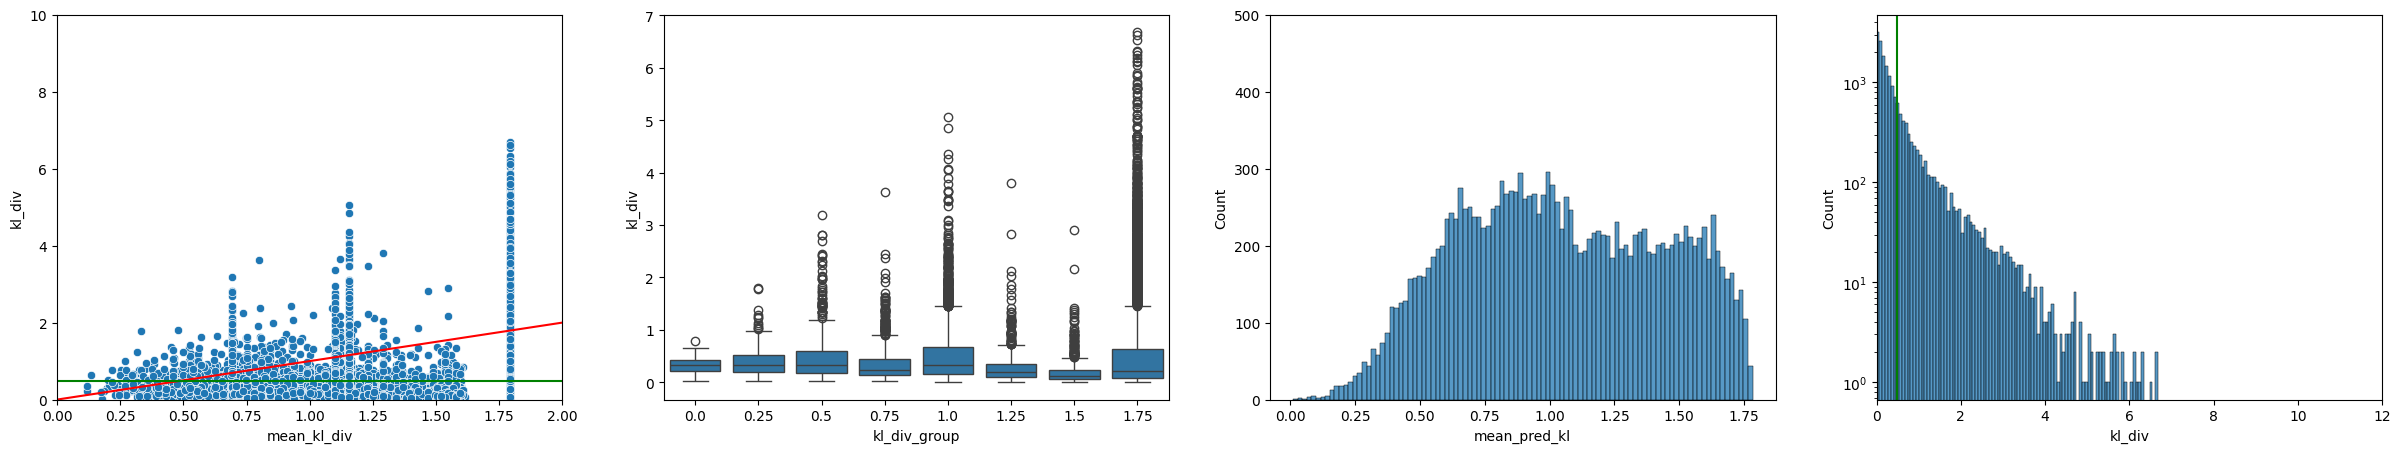

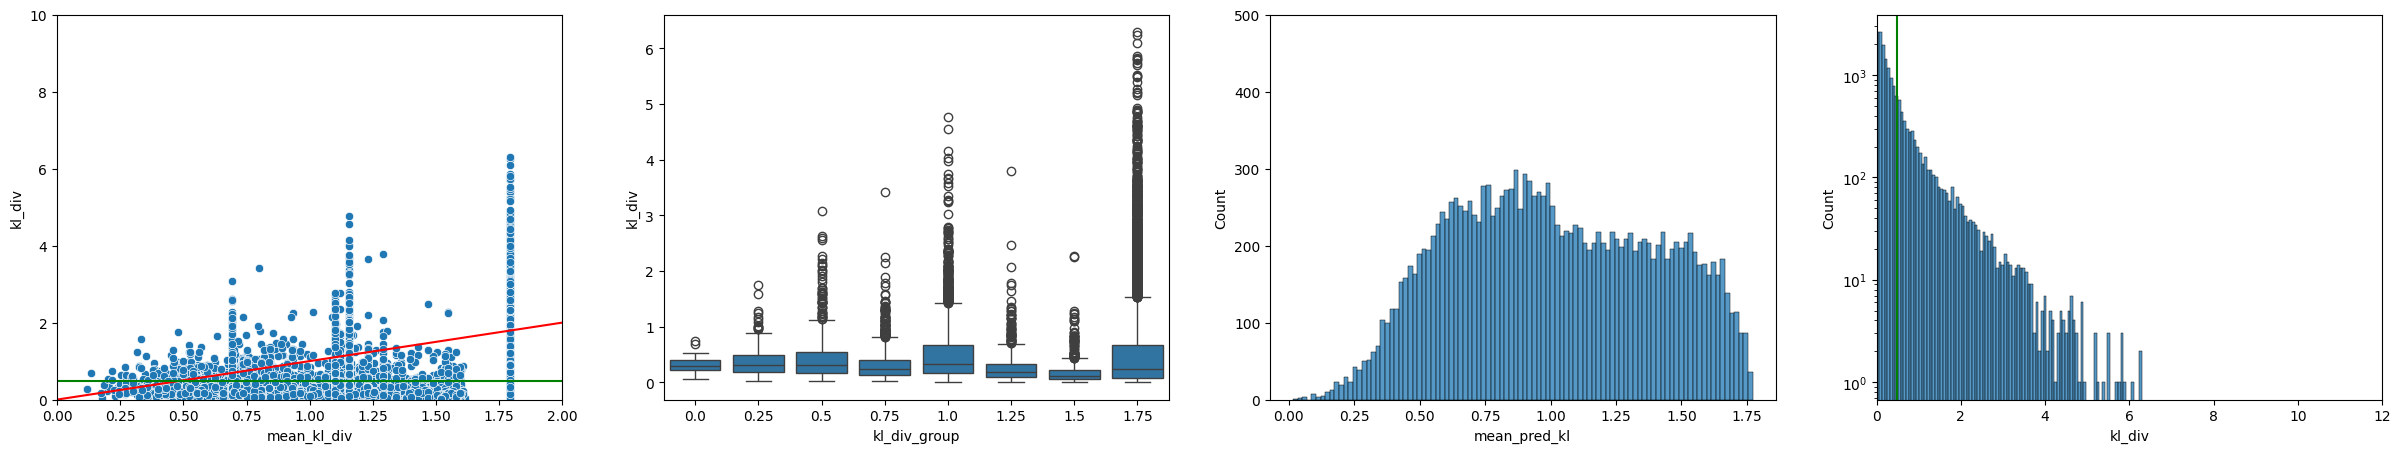

In [10]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-ema-new-hook-nokl/subm"
analyze_subm_dir(fold_dir, plot=True)

In [11]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-rawlong-kl1/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5685_0.3271 |fold 1: f1_9_0.4941_0.3077 |fold 2: f2_9_0.5598_0.3294 |fold 3: f3_9_0.5259_0.3216 |fold 4: f4_8_0.4934_0.2990 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5283462514442722 g10 score: 0.25885056307713117
score list: [0.25885056307713117, 0.5283462514442722, 0.5685, 0.4941, 0.5598, 0.5259, 0.4934]
Sort by the score at index -1
fold 0: f0_8_0.5711_0.3259 |fold 1: f1_8_0.4961_0.3074 |fold 2: f2_9_0.5598_0.3294 |fold 3: f3_7_0.5295_0.3178 |fold 4: f4_8_0.4934_0.2990 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5299899766537169 g10 score: 0.2573764028637114
score list: [0.2573764028637114, 0.5299899766537169, 0.5711, 0.4961, 0.5598, 0.5295, 0.4934]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16881285598013634, 0.06602636355810163, 0.04534960699414913, 0.0634997307148543, 0.09580094795223558, 0.08885674624479517]
['seizure_vote', 'l

In [12]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5546_0.3213 |fold 1: f1_9_0.4892_0.3048 |fold 2: f2_9_0.5275_0.3294 |fold 3: f3_9_0.5219_0.3140 |fold 4: f4_9_0.5008_0.3077 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5188059942368386 g10 score: 0.25537878783010287
score list: [0.25537878783010287, 0.5188059942368386, 0.5546, 0.4892, 0.5275, 0.5219, 0.5008]
Sort by the score at index -1
fold 0: f0_7_0.5574_0.3207 |fold 1: f1_9_0.4892_0.3048 |fold 2: f2_6_0.5328_0.3278 |fold 3: f3_8_0.5246_0.3126 |fold 4: f4_8_0.5035_0.3076 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5214996981856385 g10 score: 0.25355716773519327
score list: [0.25355716773519327, 0.5214996981856385, 0.5574, 0.4892, 0.5328, 0.5246, 0.5035]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1619784970286381, 0.06574839675781229, 0.045464941276323965, 0.06485178467009803, 0.09201486964282247, 0.08874750486114372]
['seizure_vote',

Sort by the score at index -2
fold 0: f0_8_0.5279_0.3257 |fold 1: f1_8_0.4812_0.3076 |fold 2: f2_7_0.5123_0.3155 |fold 3: f3_9_0.5077_0.3167 |fold 4: f4_6_0.4717_0.2840 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5001911905107845 g10 score: 0.25482917452257325
score list: [0.25482917452257325, 0.5001911905107845, 0.5279, 0.4812, 0.5123, 0.5077, 0.4717]
Sort by the score at index -1
fold 0: f0_6_0.5386_0.3193 |fold 1: f1_5_0.4833_0.2997 |fold 2: f2_7_0.5123_0.3155 |fold 3: f3_4_0.5258_0.3089 |fold 4: f4_8_0.4786_0.2819 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5077150624507253 g10 score: 0.24636270444509137
score list: [0.24636270444509137, 0.5077150624507253, 0.5386, 0.4833, 0.5123, 0.5258, 0.4786]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.14949442534237978, 0.06398993631547525, 0.04886475127937197, 0.06421099329292226, 0.08786906244056099, 0.0857620218400743]
['seizure_vote', 

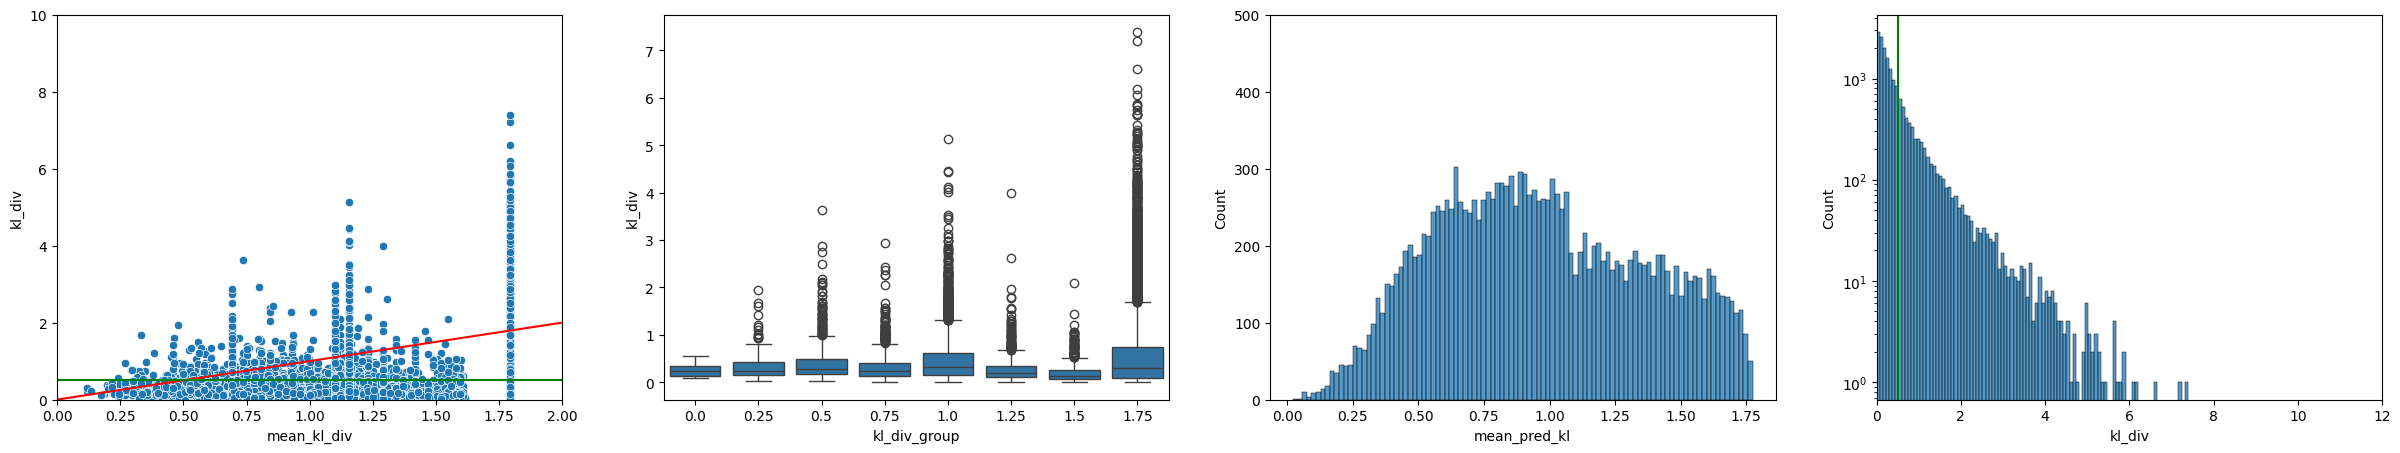

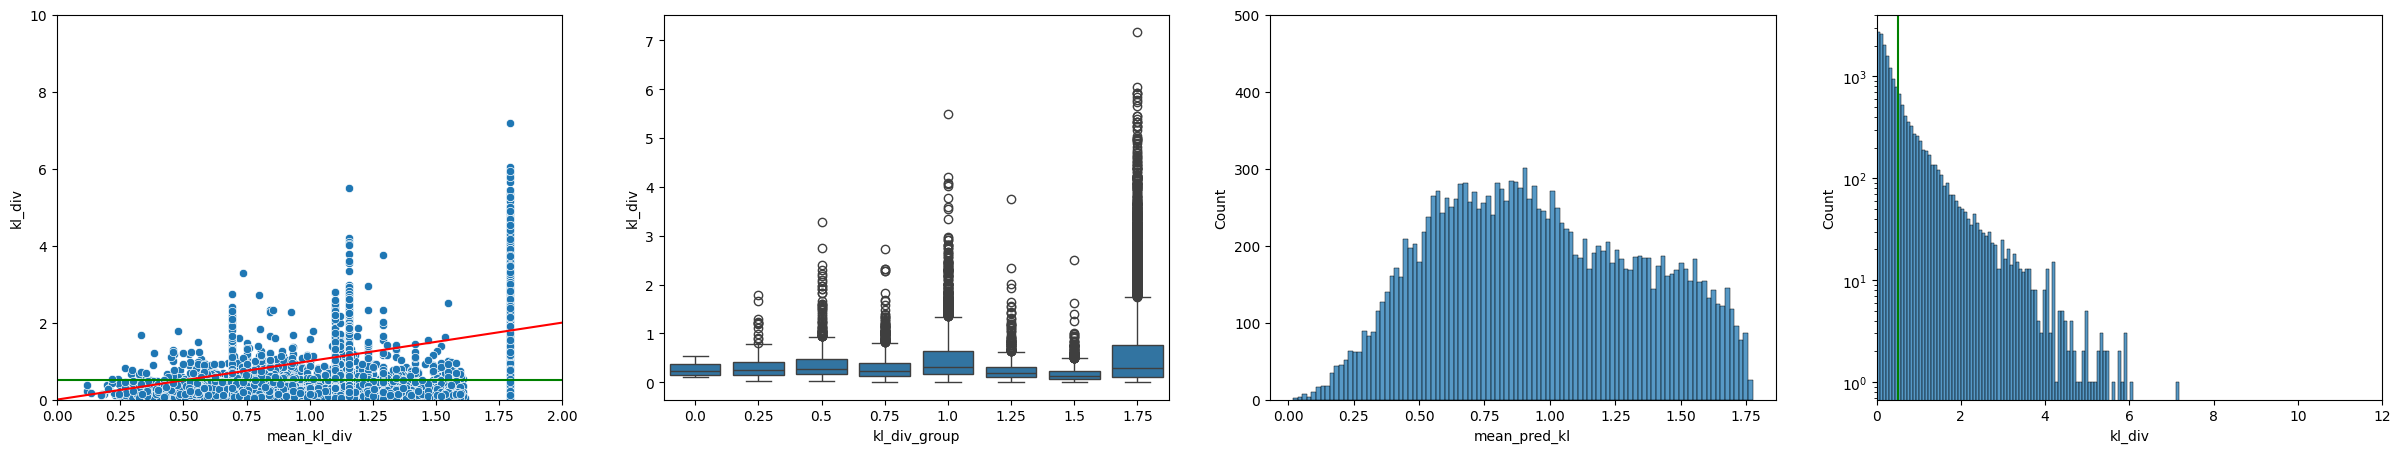

In [13]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1/subm"
analyze_subm_dir(fold_dir, plot=True)

In [14]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-vits-w025-3imgs-kl1/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5870_0.3393 |fold 1: f1_9_0.4941_0.3110 |fold 2: f2_9_0.5415_0.3445 |fold 3: f3_9_0.5241_0.3232 |fold 4: f4_9_0.5200_0.3201 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5333192428775265 g10 score: 0.26696615003291446
score list: [0.26696615003291446, 0.5333192428775265, 0.587, 0.4941, 0.5415, 0.5241, 0.52]
Sort by the score at index -1
fold 0: f0_9_0.5870_0.3393 |fold 1: f1_9_0.4941_0.3110 |fold 2: f2_6_0.5487_0.3405 |fold 3: f3_9_0.5241_0.3232 |fold 4: f4_9_0.5200_0.3201 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5347528809460312 g10 score: 0.2660592241970429
score list: [0.2660592241970429, 0.5347528809460312, 0.587, 0.4941, 0.5487, 0.5241, 0.52]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16853062996271445, 0.06896255209848738, 0.052283938578087656, 0.06482195379181607, 0.09204853872431736, 0.08667162972210361]
['seizure_vote', 'lpd_v

In [15]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1-reset/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5249_0.3055 |fold 1: f1_9_0.4874_0.2960 |fold 2: f2_9_0.5204_0.3207 |fold 3: f3_9_0.5136_0.3074 |fold 4: f4_9_0.4773_0.3014 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5047341162658288 g10 score: 0.24948383984643
score list: [0.24948383984643, 0.5047341162658288, 0.5249, 0.4874, 0.5204, 0.5136, 0.4773]
Sort by the score at index -1
fold 0: f0_7_0.5271_0.3053 |fold 1: f1_9_0.4874_0.2960 |fold 2: f2_6_0.5279_0.3181 |fold 3: f3_8_0.5143_0.3074 |fold 4: f4_9_0.4773_0.3014 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5068137220853295 g10 score: 0.24822212871992388
score list: [0.24822212871992388, 0.5068137220853295, 0.5271, 0.4874, 0.5279, 0.5143, 0.4773]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15626502883464946, 0.06417240626586036, 0.04939877711580896, 0.06230236689094599, 0.08844842980415805, 0.08414710735440604]
['seizure_vote', 'lpd_

In [16]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-reset-fixsize-long05/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5408_0.3145 |fold 1: f1_9_0.4731_0.2893 |fold 2: f2_9_0.5217_0.3226 |fold 3: f3_8_0.5094_0.3153 |fold 4: f4_9_0.4786_0.3010 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5047224968755635 g10 score: 0.252282854268819
score list: [0.252282854268819, 0.5047224968755635, 0.5408, 0.4731, 0.5217, 0.5094, 0.4786]
Sort by the score at index -1
fold 0: f0_8_0.5426_0.3127 |fold 1: f1_9_0.4731_0.2893 |fold 2: f2_7_0.5257_0.3179 |fold 3: f3_7_0.5111_0.3121 |fold 4: f4_7_0.4852_0.2997 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5075380558011164 g10 score: 0.24970070247095957
score list: [0.24970070247095957, 0.5075380558011164, 0.5426, 0.4731, 0.5257, 0.5111, 0.4852]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15498626599577883, 0.06464529963550078, 0.048165026988162135, 0.06440381546934919, 0.0911984599081282, 0.08132362887864421]
['seizure_vote', 'lp

In [17]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-nokl/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5196_0.3227 |fold 1: f1_9_0.4644_0.3025 |fold 2: f2_7_0.4927_0.3226 |fold 3: f3_6_0.4822_0.3177 |fold 4: f4_9_0.4530_0.2943 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.48236881774980134 g10 score: 0.2625802611760683
score list: [0.2625802611760683, 0.48236881774980134, 0.5196, 0.4644, 0.4927, 0.4822, 0.453]
Sort by the score at index -1
fold 0: f0_5_0.5270_0.3200 |fold 1: f1_6_0.4666_0.2974 |fold 2: f2_4_0.5066_0.3176 |fold 3: f3_3_0.4968_0.3169 |fold 4: f4_7_0.4564_0.2932 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49068837810472754 g10 score: 0.25717854432645354
score list: [0.25717854432645354, 0.49068837810472754, 0.527, 0.4666, 0.5066, 0.4968, 0.4564]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.13236016120912455, 0.06440835956386462, 0.04738289298244752, 0.06731828798521154, 0.08582221846876785, 0.08507689754038526]
['seizure_vote',

In [18]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-longw/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5377_0.3236 |fold 1: f1_6_0.4871_0.3068 |fold 2: f2_9_0.5039_0.3108 |fold 3: f3_9_0.4964_0.3117 |fold 4: f4_8_0.4853_0.2963 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5020765743028953 g10 score: 0.2564139577991922
score list: [0.2564139577991922, 0.5020765743028953, 0.5377, 0.4871, 0.5039, 0.4964, 0.4853]
Sort by the score at index -1
fold 0: f0_5_0.5518_0.3191 |fold 1: f1_4_0.5015_0.3045 |fold 2: f2_6_0.5161_0.3066 |fold 3: f3_9_0.4964_0.3117 |fold 4: f4_8_0.4853_0.2963 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5102129489468942 g10 score: 0.25115989468248795
score list: [0.25115989468248795, 0.5102129489468942, 0.5518, 0.5015, 0.5161, 0.4964, 0.4853]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.14775601023298673, 0.06582923195594967, 0.050296715240298655, 0.06585092799399557, 0.09345325528347154, 0.07889043359619315]
['seizure_vote', 

In [19]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-longw/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_6_0.5238_0.3109 |fold 1: f1_9_0.4844_0.3002 |fold 2: f2_9_0.5074_0.3144 |fold 3: f3_9_0.4979_0.3121 |fold 4: f4_9_0.4935_0.3011 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5013990638553145 g10 score: 0.24992756972004226
score list: [0.24992756972004226, 0.5013990638553145, 0.5238, 0.4844, 0.5074, 0.4979, 0.4935]
Sort by the score at index -1
fold 0: f0_6_0.5238_0.3109 |fold 1: f1_9_0.4844_0.3002 |fold 2: f2_9_0.5074_0.3144 |fold 3: f3_8_0.4996_0.3106 |fold 4: f4_9_0.4935_0.3011 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5017325283664837 g10 score: 0.24951768238582409
score list: [0.24951768238582409, 0.5017325283664837, 0.5238, 0.4844, 0.5074, 0.4996, 0.4935]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15842147150108046, 0.06515996465558145, 0.04695599810439159, 0.06263379874657839, 0.0866477013420429, 0.08158012950563977]
['seizure_vote', 

In [20]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-4imgs-kl1/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5385_0.3193 |fold 1: f1_9_0.4819_0.3022 |fold 2: f2_9_0.5243_0.3235 |fold 3: f3_9_0.4909_0.2996 |fold 4: f4_8_0.4628_0.2912 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49969880511349074 g10 score: 0.24772894642673238
score list: [0.24772894642673238, 0.49969880511349074, 0.5385, 0.4819, 0.5243, 0.4909, 0.4628]
Sort by the score at index -1
fold 0: f0_6_0.5477_0.3159 |fold 1: f1_9_0.4819_0.3022 |fold 2: f2_9_0.5243_0.3235 |fold 3: f3_7_0.4963_0.2985 |fold 4: f4_7_0.4652_0.2899 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.503086887645825 g10 score: 0.24587409521808307
score list: [0.24587409521808307, 0.503086887645825, 0.5477, 0.4819, 0.5243, 0.4963, 0.4652]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15972640973579172, 0.06295215900664788, 0.04751787225221572, 0.05862388651227796, 0.0890254814416315, 0.08185299616492597]
['seizure_vote', 

In [21]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1-wl1000/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5385_0.3158 |fold 1: f1_9_0.4824_0.3022 |fold 2: f2_9_0.5207_0.3255 |fold 3: f3_9_0.5173_0.3174 |fold 4: f4_9_0.4745_0.2994 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5066880720115667 g10 score: 0.2546741633146837
score list: [0.2546741633146837, 0.5066880720115667, 0.5385, 0.4824, 0.5207, 0.5173, 0.4745]
Sort by the score at index -1
fold 0: f0_8_0.5431_0.3149 |fold 1: f1_9_0.4824_0.3022 |fold 2: f2_7_0.5227_0.3208 |fold 3: f3_7_0.5228_0.3153 |fold 4: f4_9_0.4745_0.2994 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5091172764194825 g10 score: 0.2529652409670144
score list: [0.2529652409670144, 0.5091172764194825, 0.5431, 0.4824, 0.5227, 0.5228, 0.4745]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1575619900979038, 0.0656695699589096, 0.04700563044476618, 0.06416746757216696, 0.08939264833150926, 0.08289076560631094]
['seizure_vote', 'lpd_

In [22]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvits-w025-3imgs-kl1-wl100/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5290_0.3218 |fold 1: f1_7_0.4721_0.2921 |fold 2: f2_7_0.5036_0.3142 |fold 3: f3_6_0.5037_0.3071 |fold 4: f4_8_0.4725_0.2897 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49618490602038656 g10 score: 0.25195045883514117
score list: [0.25195045883514117, 0.49618490602038656, 0.529, 0.4721, 0.5036, 0.5037, 0.4725]
Sort by the score at index -1
fold 0: f0_5_0.5346_0.3147 |fold 1: f1_7_0.4721_0.2921 |fold 2: f2_4_0.5311_0.3135 |fold 3: f3_5_0.5161_0.3049 |fold 4: f4_5_0.4750_0.2813 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5057587336228418 g10 score: 0.24445567922260839
score list: [0.24445567922260839, 0.5057587336228418, 0.5346, 0.4721, 0.5311, 0.5161, 0.475]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1487223268668932, 0.06051354771915811, 0.04490912423655743, 0.06487032982511387, 0.09149066956983176, 0.08567890780283222]
['seizure_vote', 

In [23]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-wl250-prefilt/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5316_0.3186 |fold 1: f1_9_0.5010_0.3040 |fold 2: f2_9_0.5097_0.3214 |fold 3: f3_9_0.4973_0.3140 |fold 4: f4_9_0.4840_0.2966 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5047155222384169 g10 score: 0.2520433214534
score list: [0.2520433214534, 0.5047155222384169, 0.5316, 0.501, 0.5097, 0.4973, 0.484]
Sort by the score at index -1
fold 0: f0_5_0.5350_0.3154 |fold 1: f1_9_0.5010_0.3040 |fold 2: f2_6_0.5240_0.3172 |fold 3: f3_7_0.4986_0.3107 |fold 4: f4_9_0.4840_0.2966 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5085430924585447 g10 score: 0.24945037596975317
score list: [0.24945037596975317, 0.5085430924585447, 0.535, 0.501, 0.524, 0.4986, 0.484]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15505931144339535, 0.06529580017663028, 0.0490348156941331, 0.06375910681577107, 0.08888220108583669, 0.08268428702265043]
['seizure_vote', 'lpd_vote', 'g

In [24]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1-wl250-prefilt/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5660_0.3190 |fold 1: f1_9_0.4867_0.2982 |fold 2: f2_9_0.5324_0.3171 |fold 3: f3_9_0.5163_0.3260 |fold 4: f4_8_0.4912_0.3034 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5185002393067657 g10 score: 0.2558395961162108
score list: [0.2558395961162108, 0.5185002393067657, 0.566, 0.4867, 0.5324, 0.5163, 0.4912]
Sort by the score at index -1
fold 0: f0_6_0.5737_0.3183 |fold 1: f1_9_0.4867_0.2982 |fold 2: f2_9_0.5324_0.3171 |fold 3: f3_6_0.5173_0.3148 |fold 4: f4_7_0.4947_0.3024 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5209447880943324 g10 score: 0.25188145509404886
score list: [0.25188145509404886, 0.5209447880943324, 0.5737, 0.4867, 0.5324, 0.5173, 0.4947]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16237107012613936, 0.06452398535165883, 0.04818598787698431, 0.0630146944641728, 0.09538543515299296, 0.08501906633481746]
['seizure_vote', 'lp

In [25]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-wl80-prefilt/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5441_0.3166 |fold 1: f1_9_0.4863_0.2990 |fold 2: f2_9_0.5101_0.3159 |fold 3: f3_9_0.5127_0.3098 |fold 4: f4_9_0.5050_0.3048 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5116239024491883 g10 score: 0.2521553483947637
score list: [0.2521553483947637, 0.5116239024491883, 0.5441, 0.4863, 0.5101, 0.5127, 0.505]
Sort by the score at index -1
fold 0: f0_7_0.5473_0.3154 |fold 1: f1_9_0.4863_0.2990 |fold 2: f2_8_0.5156_0.3156 |fold 3: f3_7_0.5160_0.3088 |fold 4: f4_8_0.5065_0.3045 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5143334996922413 g10 score: 0.2512101027000707
score list: [0.2512101027000707, 0.5143334996922413, 0.5473, 0.4863, 0.5156, 0.516, 0.5065]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16473727934405177, 0.06345441310913685, 0.04714944609352401, 0.06383960151777912, 0.0892293505212258, 0.08321381186347082]
['seizure_vote', 'lpd_v

In [26]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5178_0.3046 |fold 1: f1_7_0.4839_0.2995 |fold 2: f2_9_0.5167_0.3119 |fold 3: f3_7_0.5026_0.3065 |fold 4: f4_7_0.4777_0.2912 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4997338853039669 g10 score: 0.24684078204071744
score list: [0.24684078204071744, 0.4997338853039669, 0.5178, 0.4839, 0.5167, 0.5026, 0.4777]
Sort by the score at index -1
fold 0: f0_7_0.5178_0.3046 |fold 1: f1_5_0.4904_0.2988 |fold 2: f2_9_0.5167_0.3119 |fold 3: f3_6_0.5049_0.3065 |fold 4: f4_6_0.4834_0.2894 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5026295615095739 g10 score: 0.24540509672710845
score list: [0.24540509672710845, 0.5026295615095739, 0.5178, 0.4904, 0.5167, 0.5049, 0.4834]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15774500386360815, 0.06356848188302693, 0.047513963129585786, 0.06279564843556384, 0.08621945071678966, 0.08189133727539251]
['seizure_vote'

In [27]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-l7-015/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_6_0.5393_0.3077 |fold 1: f1_9_0.5217_0.3065 |fold 2: f2_9_0.5485_0.3124 |fold 3: f3_9_0.5194_0.3017 |fold 4: f4_9_0.4987_0.2987 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5255223390130558 g10 score: 0.24299321475991845
score list: [0.24299321475991845, 0.5255223390130558, 0.5393, 0.5217, 0.5485, 0.5194, 0.4987]
Sort by the score at index -1
fold 0: f0_7_0.5410_0.3067 |fold 1: f1_9_0.5217_0.3065 |fold 2: f2_9_0.5485_0.3124 |fold 3: f3_8_0.5194_0.3014 |fold 4: f4_8_0.5004_0.2981 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5261919883612705 g10 score: 0.24260439559133484
score list: [0.24260439559133484, 0.5261919883612705, 0.541, 0.5217, 0.5485, 0.5194, 0.5004]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.18598948548860844, 0.06326165370595128, 0.04767936089956914, 0.06376722299677923, 0.08984556975678903, 0.07497904616535868]
['seizure_vote', 

In [28]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl1024/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5271_0.3137 |fold 1: f1_9_0.4904_0.3087 |fold 2: f2_9_0.5018_0.3169 |fold 3: f3_9_0.5006_0.3142 |fold 4: f4_9_0.5083_0.3067 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5056310928516227 g10 score: 0.2559342854334571
score list: [0.2559342854334571, 0.5056310928516227, 0.5271, 0.4904, 0.5018, 0.5006, 0.5083]
Sort by the score at index -1
fold 0: f0_7_0.5271_0.3137 |fold 1: f1_9_0.4904_0.3087 |fold 2: f2_8_0.5065_0.3158 |fold 3: f3_8_0.5015_0.3118 |fold 4: f4_8_0.5100_0.3062 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5071030758840461 g10 score: 0.25473059567159134
score list: [0.25473059567159134, 0.5071030758840461, 0.5271, 0.4904, 0.5065, 0.5015, 0.51]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15828465914915957, 0.06715881825490985, 0.04738549867476932, 0.06337249771497584, 0.08717938479398733, 0.08225023426382073]
['seizure_vote', 'lp

In [29]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-4imgs-kl1-bandclip-wl200/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5305_0.3109 |fold 1: f1_9_0.4749_0.3045 |fold 2: f2_8_0.5023_0.3203 |fold 3: f3_9_0.5069_0.3050 |fold 4: f4_9_0.4666_0.2862 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49623614183977927 g10 score: 0.24779632345572752
score list: [0.24779632345572752, 0.49623614183977927, 0.5305, 0.4749, 0.5023, 0.5069, 0.4666]
Sort by the score at index -1
fold 0: f0_7_0.5305_0.3109 |fold 1: f1_7_0.4774_0.3023 |fold 2: f2_5_0.5332_0.3172 |fold 3: f3_7_0.5124_0.3035 |fold 4: f4_7_0.4719_0.2854 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5050887561261612 g10 score: 0.24381597049056652
score list: [0.24381597049056652, 0.5050887561261612, 0.5305, 0.4774, 0.5332, 0.5124, 0.4719]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16077804713715121, 0.06184919840626802, 0.04712511790672039, 0.05996103558568523, 0.0884140119994589, 0.07810873080449549]
['seizure_vote'

In [30]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-noreshape/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5272_0.3137 |fold 1: f1_9_0.4891_0.3042 |fold 2: f2_9_0.5315_0.3229 |fold 3: f3_7_0.5075_0.3086 |fold 4: f4_9_0.4835_0.2954 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5077773777261064 g10 score: 0.25057101965472495
score list: [0.25057101965472495, 0.5077773777261064, 0.5272, 0.4891, 0.5315, 0.5075, 0.4835]
Sort by the score at index -1
fold 0: f0_7_0.5272_0.3137 |fold 1: f1_7_0.4967_0.3027 |fold 2: f2_9_0.5315_0.3229 |fold 3: f3_7_0.5075_0.3086 |fold 4: f4_8_0.4843_0.2930 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5094624996991537 g10 score: 0.24949948497151456
score list: [0.24949948497151456, 0.5094624996991537, 0.5272, 0.4967, 0.5315, 0.5075, 0.4843]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16038759841135378, 0.06499581994535442, 0.0474336061242598, 0.06456297110239922, 0.08956284126236573, 0.08083454088037352]
['seizure_vote', 

In [31]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w050-3imgs-kl1-bandclip-wl200/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5253_0.3107 |fold 1: f1_9_0.4987_0.3067 |fold 2: f2_9_0.5219_0.3180 |fold 3: f3_7_0.5094_0.3087 |fold 4: f4_9_0.4891_0.2963 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5088619989933255 g10 score: 0.24978738084605195
score list: [0.24978738084605195, 0.5088619989933255, 0.5253, 0.4987, 0.5219, 0.5094, 0.4891]
Sort by the score at index -1
fold 0: f0_6_0.5299_0.3097 |fold 1: f1_8_0.4991_0.3063 |fold 2: f2_9_0.5219_0.3180 |fold 3: f3_6_0.5150_0.3084 |fold 4: f4_9_0.4891_0.2963 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.510995806879011 g10 score: 0.24937359668987577
score list: [0.24937359668987577, 0.510995806879011, 0.5299, 0.4991, 0.5219, 0.515, 0.4891]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16074830073057012, 0.06317417618882437, 0.05040272973495103, 0.06587085133943132, 0.08985692892218841, 0.07880901207736013]
['seizure_vote', 'l

In [32]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-longrawfull/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5429_0.3235 |fold 1: f1_8_0.4683_0.2951 |fold 2: f2_7_0.5240_0.3257 |fold 3: f3_8_0.4999_0.3062 |fold 4: f4_9_0.4897_0.2986 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5049807269470316 g10 score: 0.25280595728923805
score list: [0.25280595728923805, 0.5049807269470316, 0.5429, 0.4683, 0.524, 0.4999, 0.4897]
Sort by the score at index -1
fold 0: f0_6_0.5469_0.3172 |fold 1: f1_6_0.4695_0.2923 |fold 2: f2_4_0.5310_0.3220 |fold 3: f3_5_0.5174_0.2993 |fold 4: f4_7_0.4944_0.2980 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5118422654291096 g10 score: 0.24550595868044275
score list: [0.24550595868044275, 0.5118422654291096, 0.5469, 0.4695, 0.531, 0.5174, 0.4944]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16227070432618204, 0.062765945080178, 0.04782589578570224, 0.059167284511560884, 0.08820916379530054, 0.08474173344810779]
['seizure_vote', 'l

In [33]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5277_0.3118 |fold 1: f1_9_0.4813_0.2994 |fold 2: f2_9_0.5127_0.3140 |fold 3: f3_9_0.5081_0.3072 |fold 4: f4_9_0.4787_0.2957 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5017059563704583 g10 score: 0.24927298031362666
score list: [0.24927298031362666, 0.5017059563704583, 0.5277, 0.4813, 0.5127, 0.5081, 0.4787]
Sort by the score at index -1
fold 0: f0_6_0.5324_0.3109 |fold 1: f1_9_0.4813_0.2994 |fold 2: f2_7_0.5179_0.3118 |fold 3: f3_6_0.5109_0.3036 |fold 4: f4_9_0.4787_0.2957 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5042597948637496 g10 score: 0.24801152422967962
score list: [0.24801152422967962, 0.5042597948637496, 0.5324, 0.4813, 0.5179, 0.5109, 0.4787]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15765368686809267, 0.06330296515782911, 0.046350385586894575, 0.06449622787718756, 0.0881120461067262, 0.08179064477372831]
['seizure_vote',

In [34]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-wl200-april/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5205_0.3201 |fold 1: f1_8_0.4804_0.2976 |fold 2: f2_7_0.5202_0.3284 |fold 3: f3_9_0.5143_0.3091 |fold 4: f4_9_0.4791_0.2962 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.502913270249344 g10 score: 0.25416895841648973
score list: [0.25416895841648973, 0.502913270249344, 0.5205, 0.4804, 0.5202, 0.5143, 0.4791]
Sort by the score at index -1
fold 0: f0_7_0.5205_0.3201 |fold 1: f1_7_0.4814_0.2930 |fold 2: f2_6_0.5253_0.3233 |fold 3: f3_6_0.5254_0.3047 |fold 4: f4_6_0.4858_0.2903 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5076654275659175 g10 score: 0.24923832851901026
score list: [0.24923832851901026, 0.5076654275659175, 0.5205, 0.4814, 0.5253, 0.5254, 0.4858]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15181610078668442, 0.06805659100611271, 0.04875960705707733, 0.06504998590699876, 0.09063927934268112, 0.07859170614978975]
['seizure_vote', '

In [35]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-avgmax/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5127_0.3131 |fold 1: f1_9_0.4886_0.2940 |fold 2: f2_9_0.5282_0.3214 |fold 3: f3_9_0.5246_0.3117 |fold 4: f4_9_0.5223_0.3202 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5152787373394672 g10 score: 0.25018879880982037
score list: [0.25018879880982037, 0.5152787373394672, 0.5127, 0.4886, 0.5282, 0.5246, 0.5223]
Sort by the score at index -1
fold 0: f0_9_0.5127_0.3131 |fold 1: f1_9_0.4886_0.2940 |fold 2: f2_9_0.5282_0.3214 |fold 3: f3_9_0.5246_0.3117 |fold 4: f4_9_0.5223_0.3202 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5152787373394672 g10 score: 0.25018879880982037
score list: [0.25018879880982037, 0.5152787373394672, 0.5127, 0.4886, 0.5282, 0.5246, 0.5223]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16965369044182238, 0.06295339465860597, 0.05002664096221847, 0.06533148748176147, 0.08626256308428079, 0.08105096071077808]
['seizure_vote',

In [36]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvits-w025-3imgs-kl1-bandclip/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5425_0.3174 |fold 1: f1_8_0.4890_0.3078 |fold 2: f2_9_0.4952_0.3235 |fold 3: f3_7_0.5022_0.3068 |fold 4: f4_7_0.4705_0.2840 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49986435682109265 g10 score: 0.2533664090975782
score list: [0.2533664090975782, 0.49986435682109265, 0.5425, 0.489, 0.4952, 0.5022, 0.4705]
Sort by the score at index -1
fold 0: f0_4_0.5453_0.3080 |fold 1: f1_7_0.4901_0.3052 |fold 2: f2_6_0.5092_0.3170 |fold 3: f3_6_0.5054_0.3006 |fold 4: f4_4_0.4848_0.2810 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5069790128575061 g10 score: 0.24429547645533603
score list: [0.24429547645533603, 0.5069790128575061, 0.5453, 0.4901, 0.5092, 0.5054, 0.4848]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15029178208413826, 0.06810747112851527, 0.05081661275130499, 0.0666365339686586, 0.09450635809835163, 0.0695055987901239]
['seizure_vote', 'l

In [37]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-avgmax/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5153_0.3048 |fold 1: f1_9_0.4809_0.3049 |fold 2: f2_9_0.5143_0.3219 |fold 3: f3_9_0.5107_0.3027 |fold 4: f4_8_0.4869_0.2869 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5016349210718339 g10 score: 0.24721612170089752
score list: [0.24721612170089752, 0.5016349210718339, 0.5153, 0.4809, 0.5143, 0.5107, 0.4869]
Sort by the score at index -1
fold 0: f0_6_0.5166_0.3028 |fold 1: f1_6_0.4869_0.3032 |fold 2: f2_6_0.5332_0.3182 |fold 3: f3_6_0.5137_0.3010 |fold 4: f4_7_0.4892_0.2862 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5079279564558925 g10 score: 0.24369328470134818
score list: [0.24369328470134818, 0.5079279564558925, 0.5166, 0.4869, 0.5332, 0.5137, 0.4892]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15880112948872377, 0.06490992195273558, 0.05029936731626898, 0.06416600048063888, 0.0886052227693508, 0.07485327906411593]
['seizure_vote', 

In [38]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-20s/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5503_0.3244 |fold 1: f1_8_0.4748_0.3024 |fold 2: f2_6_0.5157_0.3192 |fold 3: f3_6_0.4983_0.3116 |fold 4: f4_9_0.4765_0.2858 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5031248110792721 g10 score: 0.2532123647022889
score list: [0.2532123647022889, 0.5031248110792721, 0.5503, 0.4748, 0.5157, 0.4983, 0.4765]
Sort by the score at index -1
fold 0: f0_8_0.5565_0.3243 |fold 1: f1_7_0.4764_0.2976 |fold 2: f2_5_0.5244_0.3168 |fold 3: f3_6_0.4983_0.3116 |fold 4: f4_9_0.4765_0.2858 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5063849498071308 g10 score: 0.25064436178709965
score list: [0.25064436178709965, 0.5063849498071308, 0.5565, 0.4764, 0.5244, 0.4983, 0.4765]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15219807143653122, 0.06487559316438699, 0.04462832198643468, 0.06455835613017123, 0.08977887616915513, 0.08708559219259294]
['seizure_vote', '

In [39]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-3imgs-kl1-bandclip-20s/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5262_0.3204 |fold 1: f1_9_0.4729_0.3063 |fold 2: f2_9_0.5121_0.3229 |fold 3: f3_8_0.4943_0.3067 |fold 4: f4_9_0.4783_0.2999 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49675963934249523 g10 score: 0.2531333307942752
score list: [0.2531333307942752, 0.49675963934249523, 0.5262, 0.4729, 0.5121, 0.4943, 0.4783]
Sort by the score at index -1
fold 0: f0_5_0.5303_0.3151 |fold 1: f1_9_0.4729_0.3063 |fold 2: f2_7_0.5135_0.3189 |fold 3: f3_5_0.5016_0.3013 |fold 4: f4_9_0.4783_0.2999 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4993301074601584 g10 score: 0.2500345697951136
score list: [0.2500345697951136, 0.4993301074601584, 0.5303, 0.4729, 0.5135, 0.5016, 0.4783]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15366362402408096, 0.06619139452701797, 0.04597213804715032, 0.06364409348701675, 0.08857890344952364, 0.07870948580770547]
['seizure_vote', '

In [40]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-4imgs-kl1-bandclip-lrf16-12s/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5357_0.3126 |fold 1: f1_9_0.4688_0.2981 |fold 2: f2_9_0.5086_0.3171 |fold 3: f3_8_0.4918_0.3002 |fold 4: f4_9_0.4703_0.2874 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4950414281218586 g10 score: 0.24692750496108642
score list: [0.24692750496108642, 0.4950414281218586, 0.5357, 0.4688, 0.5086, 0.4918, 0.4703]
Sort by the score at index -1
fold 0: f0_6_0.5381_0.3102 |fold 1: f1_7_0.4725_0.2960 |fold 2: f2_8_0.5102_0.3169 |fold 3: f3_6_0.4951_0.2974 |fold 4: f4_7_0.4724_0.2849 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49764207903364055 g10 score: 0.2432952373572062
score list: [0.2432952373572062, 0.49764207903364055, 0.5381, 0.4725, 0.5102, 0.4951, 0.4724]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15486042915762105, 0.06362875567591815, 0.04734484448205313, 0.06140911990988935, 0.09030970989577786, 0.07748856900059907]
['seizure_vote',

In [41]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-w025-4imgs-kl1-bandclip-lrf16-12s/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_5_0.5184_0.3131 |fold 1: f1_7_0.4708_0.2998 |fold 2: f2_5_0.5248_0.3234 |fold 3: f3_8_0.4941_0.3011 |fold 4: f4_9_0.4826_0.2876 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49813269508262986 g10 score: 0.24895104492728684
score list: [0.24895104492728684, 0.49813269508262986, 0.5184, 0.4708, 0.5248, 0.4941, 0.4826]
Sort by the score at index -1
fold 0: f0_6_0.5258_0.3130 |fold 1: f1_5_0.4809_0.2940 |fold 2: f2_7_0.5256_0.3218 |fold 3: f3_5_0.5110_0.2954 |fold 4: f4_9_0.4826_0.2876 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.50518330524934 g10 score: 0.2442560770278321
score list: [0.2442560770278321, 0.50518330524934, 0.5258, 0.4809, 0.5256, 0.511, 0.4826]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15329042655387007, 0.07040595190376528, 0.04853445895800951, 0.06272910501498948, 0.08757363426086903, 0.07559911839112644]
['seizure_vote', 'lpd

In [42]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-3imgs-kl1-bandclip-lrf16-12s/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5339_0.3097 |fold 1: f1_7_0.4726_0.3076 |fold 2: f2_8_0.5361_0.3477 |fold 3: f3_7_0.5068_0.3135 |fold 4: f4_9_0.4752_0.2985 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5049160284814732 g10 score: 0.25638060181440864
score list: [0.25638060181440864, 0.5049160284814732, 0.5339, 0.4726, 0.5361, 0.5068, 0.4752]
Sort by the score at index -1
fold 0: f0_5_0.5378_0.3072 |fold 1: f1_8_0.4739_0.3070 |fold 2: f2_5_0.5553_0.3440 |fold 3: f3_6_0.5144_0.3092 |fold 4: f4_6_0.4831_0.2950 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5129045136489959 g10 score: 0.250823559977911
score list: [0.250823559977911, 0.5129045136489959, 0.5378, 0.4739, 0.5553, 0.5144, 0.4831]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.16222053390634267, 0.06523926975902028, 0.045408895755660365, 0.059410965922024286, 0.08816032230054162, 0.08447604083788418]
['seizure_vote', '

In [43]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-4imgs-kl1-bandclip-12s-large/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5358_0.3204 |fold 1: f1_8_0.4818_0.3016 |fold 2: f2_8_0.5213_0.3283 |fold 3: f3_8_0.4897_0.2937 |fold 4: f4_8_0.4752_0.2849 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5007600091324801 g10 score: 0.24654639686858693
score list: [0.24654639686858693, 0.5007600091324801, 0.5358, 0.4818, 0.5213, 0.4897, 0.4752]
Sort by the score at index -1
fold 0: f0_5_0.5466_0.3152 |fold 1: f1_7_0.4823_0.3013 |fold 2: f2_5_0.5349_0.3262 |fold 3: f3_6_0.4912_0.2888 |fold 4: f4_7_0.4769_0.2839 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5063781166668073 g10 score: 0.24282173180454777
score list: [0.24282173180454777, 0.5063781166668073, 0.5466, 0.4823, 0.5349, 0.4912, 0.4769]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1583000088315288, 0.06503842750185686, 0.04779403807863982, 0.06147874812648374, 0.08900673430586284, 0.07914205228810804]
['seizure_vote', 

In [44]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-4imgs-kl1-wl1024/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5462_0.3151 |fold 1: f1_9_0.4684_0.3028 |fold 2: f2_9_0.5007_0.3226 |fold 3: f3_7_0.4908_0.2953 |fold 4: f4_9_0.4610_0.2864 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4934182108843845 g10 score: 0.2477619816459261
score list: [0.2477619816459261, 0.4934182108843845, 0.5462, 0.4684, 0.5007, 0.4908, 0.461]
Sort by the score at index -1
fold 0: f0_6_0.5530_0.3133 |fold 1: f1_6_0.4775_0.3005 |fold 2: f2_8_0.5027_0.3215 |fold 3: f3_5_0.4939_0.2911 |fold 4: f4_6_0.4726_0.2844 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49993262244180037 g10 score: 0.24298074953163948
score list: [0.24298074953163948, 0.49993262244180037, 0.553, 0.4775, 0.5027, 0.4939, 0.4726]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1530290311331787, 0.06247108397550804, 0.046067874585524096, 0.059611458967879595, 0.09194719120015409, 0.08029157102213998]
['seizure_vote', 

In [45]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-4imgs-w025-kl1-avgmax/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_8_0.5331_0.3202 |fold 1: f1_7_0.4754_0.2995 |fold 2: f2_9_0.5146_0.3165 |fold 3: f3_6_0.5048_0.3021 |fold 4: f4_7_0.4765_0.2917 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5008882053898525 g10 score: 0.25097605330232964
score list: [0.25097605330232964, 0.5008882053898525, 0.5331, 0.4754, 0.5146, 0.5048, 0.4765]
Sort by the score at index -1
fold 0: f0_7_0.5343_0.3175 |fold 1: f1_5_0.4945_0.2970 |fold 2: f2_9_0.5146_0.3165 |fold 3: f3_6_0.5048_0.3021 |fold 4: f4_5_0.4780_0.2905 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5052561026982431 g10 score: 0.2472818769674158
score list: [0.2472818769674158, 0.5052561026982431, 0.5343, 0.4945, 0.5146, 0.5048, 0.478]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15394115946135076, 0.06975243963233733, 0.04563177983972451, 0.063528406736588, 0.086672728784888, 0.08136169093496398]
['seizure_vote', 'lpd_v

In [46]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl1-newlrorder/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5773_0.3349 |fold 1: f1_7_0.5077_0.3228 |fold 2: f2_9_0.5348_0.3295 |fold 3: f3_9_0.5161_0.3020 |fold 4: f4_9_0.5114_0.3038 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5294514607317505 g10 score: 0.25472375944448866
score list: [0.25472375944448866, 0.5294514607317505, 0.5773, 0.5077, 0.5348, 0.5161, 0.5114]
Sort by the score at index -1
fold 0: f0_6_0.5787_0.3332 |fold 1: f1_7_0.5077_0.3228 |fold 2: f2_9_0.5348_0.3295 |fold 3: f3_9_0.5161_0.3020 |fold 4: f4_8_0.5120_0.3035 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5298673667036936 g10 score: 0.2541617623667469
score list: [0.2541617623667469, 0.5298673667036936, 0.5787, 0.5077, 0.5348, 0.5161, 0.512]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1826796576132783, 0.06285227349882144, 0.04628094812969867, 0.0616853670101234, 0.08922175922924977, 0.08673145525057903]
['seizure_vote', 'lpd

In [47]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl1-oldlrorder/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_9_0.5681_0.3345 |fold 1: f1_9_0.5179_0.3290 |fold 2: f2_9_0.5336_0.3206 |fold 3: f3_9_0.5189_0.3108 |fold 4: f4_9_0.5111_0.3011 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5299194977695517 g10 score: 0.2574300323299037
score list: [0.2574300323299037, 0.5299194977695517, 0.5681, 0.5179, 0.5336, 0.5189, 0.5111]
Sort by the score at index -1
fold 0: f0_7_0.5701_0.3328 |fold 1: f1_9_0.5179_0.3290 |fold 2: f2_8_0.5346_0.3205 |fold 3: f3_8_0.5200_0.3107 |fold 4: f4_8_0.5125_0.3006 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5310326339644428 g10 score: 0.256506085497183
score list: [0.256506085497183, 0.5310326339644428, 0.5701, 0.5179, 0.5346, 0.52, 0.5125]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.18164485662617086, 0.06344817502512175, 0.04980492317664173, 0.062443808017984055, 0.08967690148595267, 0.08290083343768066]
['seizure_vote', 'lpd_v

In [48]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl0-512/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_6_0.5181_0.3216 |fold 1: f1_9_0.4431_0.3068 |fold 2: f2_7_0.5278_0.3648 |fold 3: f3_5_0.4812_0.3106 |fold 4: f4_9_0.4313_0.2854 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.48029690616968423 g10 score: 0.2660418214142922
score list: [0.2660418214142922, 0.48029690616968423, 0.5181, 0.4431, 0.5278, 0.4812, 0.4313]
Sort by the score at index -1
fold 0: f0_4_0.5214_0.3188 |fold 1: f1_6_0.4431_0.2990 |fold 2: f2_4_0.5430_0.3583 |fold 3: f3_2_0.5073_0.3079 |fold 4: f4_6_0.4358_0.2799 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49010783461812407 g10 score: 0.25735611671095315
score list: [0.25735611671095315, 0.49010783461812407, 0.5214, 0.4431, 0.543, 0.5073, 0.4358]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.13550463704245816, 0.06419576953963181, 0.04672234598051481, 0.06279851775554035, 0.088320729661467, 0.08275490619007209]
['seizure_vote', 

In [49]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl2-512/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5370_0.3139 |fold 1: f1_8_0.4739_0.3057 |fold 2: f2_6_0.5209_0.3271 |fold 3: f3_9_0.4809_0.2995 |fold 4: f4_9_0.4664_0.2885 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4958420882956377 g10 score: 0.2492115821697445
score list: [0.2492115821697445, 0.4958420882956377, 0.537, 0.4739, 0.5209, 0.4809, 0.4664]
Sort by the score at index -1
fold 0: f0_5_0.5398_0.3111 |fold 1: f1_5_0.4824_0.3004 |fold 2: f2_7_0.5219_0.3268 |fold 3: f3_6_0.4840_0.2935 |fold 4: f4_7_0.4691_0.2859 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.49943277884652115 g10 score: 0.2437720442812616
score list: [0.2437720442812616, 0.49943277884652115, 0.5398, 0.4824, 0.5219, 0.484, 0.4691]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15348541042921388, 0.061259201423527115, 0.04962531517034704, 0.06107596875652455, 0.0899168339356506, 0.08047935858037457]
['seizure_vote', 'lp

In [50]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvits-4imgs-w025-kl1-512/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_7_0.5252_0.3194 |fold 1: f1_5_0.4854_0.2932 |fold 2: f2_6_0.5021_0.3109 |fold 3: f3_5_0.4879_0.2917 |fold 4: f4_9_0.4665_0.2822 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.4934151186082884 g10 score: 0.2423354375170905
score list: [0.2423354375170905, 0.4934151186082884, 0.5252, 0.4854, 0.5021, 0.4879, 0.4665]
Sort by the score at index -1
fold 0: f0_4_0.5456_0.3100 |fold 1: f1_2_0.5027_0.2926 |fold 2: f2_6_0.5021_0.3109 |fold 3: f3_5_0.4879_0.2917 |fold 4: f4_6_0.4685_0.2771 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5013582465334673 g10 score: 0.2386862042012954
score list: [0.2386862042012954, 0.5013582465334673, 0.5456, 0.5027, 0.5021, 0.4879, 0.4685]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15241896990998183, 0.06608067069202316, 0.049443113869875, 0.061802576729492555, 0.0873935595427564, 0.07627622786415948]
['seizure_vote', 'lpd_

In [186]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-2/hmsv6-vits-4imgs-w020-kl1/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_11_0.5664_0.2620 |fold 1: f1_11_0.5176_0.2618 |fold 2: f2_9_0.5677_0.2796 |fold 3: f3_10_0.5410_0.2775 |fold 4: f4_11_0.5189_0.2627 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5423087019588474 g10 score: 0.2683142164871349
score list: [0.2683142164871349, 0.5423087019588474, 0.5664, 0.5176, 0.5677, 0.541, 0.5189]
Sort by the score at index -1
fold 0: f0_10_0.5708_0.2603 |fold 1: f1_11_0.5176_0.2618 |fold 2: f2_7_0.5777_0.2766 |fold 3: f3_7_0.5530_0.2753 |fold 4: f4_9_0.5254_0.2620 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5488872337053277 g10 score: 0.2668275345200267
score list: [0.2668275345200267, 0.5488872337053277, 0.5708, 0.5176, 0.5777, 0.553, 0.5254]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.1792462263120884, 0.07283947716433334, 0.04902990126202415, 0.06646288089935111, 0.09082354823085884, 0.08390666809019154]
['seizure_vote', 

In [188]:
fold_dir = "/home/maxc/workspace/kaggle-hms/models-hmsv6-2/hmsv6-convnexts-3imgs-w020-kl1-lrf/subm"
analyze_subm_dir(fold_dir, plot=False)

Sort by the score at index -2
fold 0: f0_11_0.5526_0.2447 |fold 1: f1_11_0.4976_0.2534 |fold 2: f2_11_0.5717_0.2620 |fold 3: f3_11_0.5410_0.2646 |fold 4: f4_11_0.5133_0.2473 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5352387838228124 g10 score: 0.25405060510985544
score list: [0.25405060510985544, 0.5352387838228124, 0.5526, 0.4976, 0.5717, 0.541, 0.5133]
Sort by the score at index -1
fold 0: f0_9_0.5594_0.2435 |fold 1: f1_11_0.4976_0.2534 |fold 2: f2_11_0.5717_0.2620 |fold 3: f3_11_0.5410_0.2646 |fold 4: f4_11_0.5133_0.2473 |
(106800, 7) (17089, 7) (17089, 7)
(106800, 7) (5441, 7) (5441, 7)
Score: 0.5366152301383512 g10 score: 0.25379884540094594
score list: [0.25379884540094594, 0.5366152301383512, 0.5594, 0.4976, 0.5717, 0.541, 0.5133]
['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.18250940263398746, 0.06712289217926606, 0.047454059692789305, 0.061583668901780145, 0.09236325213129747, 0.0842055082836919]
['seizur

In [187]:
def ensemble_eval(dir_list):
    subm_list = []
    for d in dir_list:
        subm,_ = read_subm_dir(d)
        subm = pd.concat([pd.read_csv(f) for f in subm])
        subm_list.append(subm)
    ensemble_subm = subm_list[0].copy()
    target_columns = ensemble_subm.columns[-6:]
    for s in subm_list[1:]:
        ensemble_subm[target_columns] += s[target_columns]
    ensemble_subm[target_columns] = ensemble_subm[target_columns] / len(subm_list)
    gt_subm = pd.read_csv(GT_PATH)

    print(eval_subm(ensemble_subm, gt_subm))
    print(eval_subm_g10(ensemble_subm, gt_subm))
    return ensemble_subm


ensemble_dir_list = [
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-longw/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-longw/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-4imgs-kl1/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-4imgs-kl1-bandclip-wl200/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-longrawfull/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-wl200-april/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvits-w025-3imgs-kl1-bandclip/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-avgmax/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-20s/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-3imgs-kl1-bandclip-20s/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-4imgs-kl1-bandclip-lrf16-12s/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-w025-4imgs-kl1-bandclip-lrf16-12s/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-w025-4imgs-kl1-bandclip-12s-large/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvitt-4imgs-w025-kl1-avgmax/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl0-512/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-convnexts-4imgs-w025-kl2-512/subm",
    "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvits-4imgs-w025-kl1-512/subm",
    # "/home/maxc/workspace/kaggle-hms/models-hmsv6-2/hmsv6-vits-4imgs-w020-kl1/subm",
]
ensemble_df = ensemble_eval(ensemble_dir_list)

Sort by the score at index -1
fold 0: f0_4_0.5453_0.3080 |fold 1: f1_7_0.4901_0.3052 |fold 2: f2_6_0.5092_0.3170 |fold 3: f3_6_0.5054_0.3006 |fold 4: f4_4_0.4848_0.2810 |
Sort by the score at index -1
fold 0: f0_6_0.5166_0.3028 |fold 1: f1_6_0.4869_0.3032 |fold 2: f2_6_0.5332_0.3182 |fold 3: f3_6_0.5137_0.3010 |fold 4: f4_7_0.4892_0.2862 |
Sort by the score at index -1
fold 0: f0_5_0.5303_0.3151 |fold 1: f1_9_0.4729_0.3063 |fold 2: f2_7_0.5135_0.3189 |fold 3: f3_5_0.5016_0.3013 |fold 4: f4_9_0.4783_0.2999 |
Sort by the score at index -1
fold 0: f0_6_0.5258_0.3130 |fold 1: f1_5_0.4809_0.2940 |fold 2: f2_7_0.5256_0.3218 |fold 3: f3_5_0.5110_0.2954 |fold 4: f4_9_0.4826_0.2876 |
Sort by the score at index -1
fold 0: f0_5_0.5466_0.3152 |fold 1: f1_7_0.4823_0.3013 |fold 2: f2_5_0.5349_0.3262 |fold 3: f3_6_0.4912_0.2888 |fold 4: f4_7_0.4769_0.2839 |
Sort by the score at index -1
fold 0: f0_7_0.5343_0.3175 |fold 1: f1_5_0.4945_0.2970 |fold 2: f2_9_0.5146_0.3165 |fold 3: f3_6_0.5048_0.3021 |fol

In [52]:
analyze_subm(ensemble_df, pd.read_csv(GT_PATH))

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
[0.15610863487469495, 0.060106759111618065, 0.04530985299456542, 0.06014486748444113, 0.0872118515184061, 0.07686082524766985]


,eeg_id,eeg_sub_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,unique_id,mean_pred_kl,kl_div,reverse_kl_div,mean_kl_div
0,2061593,0,0.002513,0.003385,0.001143,0.046420,0.130499,0.816040,2061593_0,1.244453,0.156777,1.457392,1.791759
1,2366870,0,0.004875,0.043888,0.012968,0.118451,0.088203,0.731614,2366870_0,0.725780,0.148611,1.269049,1.155245
2,3851658,0,0.018639,0.573169,0.004696,0.204362,0.020895,0.178240,3851658_0,0.994269,0.131950,0.622295,1.504923
3,4559645,0,0.020146,0.019794,0.143349,0.024069,0.385542,0.407101,4559645_0,0.730190,0.382776,3.332239,1.791759
4,8027281,0,0.008315,0.668148,0.011716,0.079027,0.018482,0.214312,8027281_0,0.961153,0.279398,1.559469,1.229424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,4287566616,0,0.020078,0.319600,0.297761,0.035736,0.071335,0.255489,4287566616_0,1.157763,0.199867,1.868828,1.791759
3413,4289227381,0,0.607563,0.043491,0.002284,0.205730,0.009278,0.131654,4289227381_0,0.819740,0.331416,2.925249,1.791759
3414,4291744526,0,0.003027,0.089601,0.047059,0.065190,0.464286,0.330837,4291744526_0,0.616687,1.505342,9.574205,1.791759
3415,4292809326,0,0.005657,0.007899,0.009598,0.004644,0.037690,0.934512,4292809326_0,0.818863,0.187238,1.022474,1.429549


In [53]:
oof_result_dfs = []
oof_result_logits_dfs = []
for dir in ensemble_dir_list:
    preds_path = os.path.join(dir, "oof_result.csv")
    logits_path = os.path.join(dir, "oof_result_logits.csv")
    oof_result_dfs.append(pd.read_csv(preds_path))
    oof_result_logits_dfs.append(pd.read_csv(logits_path))
    
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

GT_PATH
# ensemble the oof results
ensemble_oof_result = oof_result_dfs[0].copy()
ensemble_oof_logits = oof_result_logits_dfs[0].copy()
for i in range(1, len(oof_result_dfs)):
    ensemble_oof_result[TARGETS] += oof_result_dfs[i][TARGETS]
    ensemble_oof_logits[TARGETS] += oof_result_logits_dfs[i][TARGETS]
ensemble_oof_result[TARGETS] = ensemble_oof_result[TARGETS] / len(oof_result_dfs)
ensemble_oof_logits[TARGETS] = ensemble_oof_logits[TARGETS] / len(oof_result_dfs)

print(eval_subm(ensemble_oof_result, pd.read_csv(GT_PATH)))
print(eval_subm_g10(ensemble_oof_result, pd.read_csv(GT_PATH)))


# apply softmax to the logits and get the score subm
ensemble_oof_result_softmax = ensemble_oof_logits.copy()
ensemble_oof_result_softmax[TARGETS] = torch.nn.functional.softmax(torch.tensor(ensemble_oof_logits[TARGETS].values), dim=1).numpy()
print("======================================= Logit ensemble scores:")
print(eval_subm(ensemble_oof_result_softmax, pd.read_csv(GT_PATH)))
print(eval_subm_g10(ensemble_oof_result_softmax, pd.read_csv(GT_PATH)))


FileNotFoundError: [Errno 2] No such file or directory: '/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/subm/oof_result.csv'